In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from utils import *
from model import * 
from matplotlib.patches import Ellipse
import scipy.io

In [3]:
def get_J(params): 
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    return J 

def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def find_amps(params, get_J, T, n_frames, init):
    m = FHN_det(params, get_J)
    res = m.evolve(T, int(n_frames), init)
    amps = np.fft.rfft(res[:, -int(n_frames/2):], axis=-1) 
    return np.abs(amps)**2 

In [3]:
# params in the order of epsilon, gamma, mu, c 
gamma = 1
c =  14.4*gamma
mu = 0.1
epsilon = 0.374
beta = 14.25*gamma

params = [epsilon, gamma, mu, c, beta, 0.05]

T = 1e3
n_frames = int(T)
init = [1, 1]

N = 200
epsilons = np.linspace(0.0001, 0.6, N)
mus = np.linspace(0.0, 0.5, N)

In [6]:
Re = np.empty((N, N))
Im = np.empty((N, N))
# Amps = np.empty((N, N))

for (i, epsilon) in enumerate(epsilons): 
    for (j, mu) in enumerate(mus):
        J = get_J([epsilon, gamma, mu, c]) 
        eigvals = np.linalg.eigvals(J)
        Re[i, j] = np.real(np.max(eigvals))
        Im[i, j] = np.imag(np.max(eigvals))
        
        # params = [epsilon, gamma, mu, c, beta]
        # amps = find_amps(params, get_J, T, n_frames, init)
        # Amps[i, j] = np.sum(amps[1:])/n_frames 

In [35]:
# np.save('Data/param_sweep_amps.npy', Amps)
# np.save('Data/param_sweep_epsilons.npy', epsilons)
# np.save('Data/param_sweep_mus.npy', mus)

In [4]:
Amps = np.load('Data/param_sweep_amps.npy')
epsilons = np.load('Data/param_sweep_epsilons.npy')
mus = np.load('Data/param_sweep_mus.npy')   

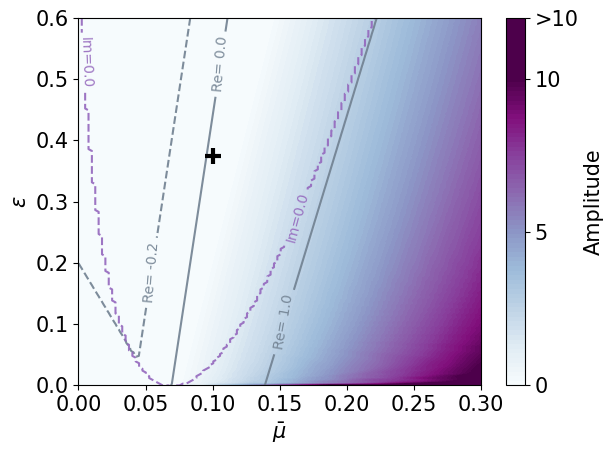

In [24]:
epsilon_map = 0.374
epsilon_frac_err = 0.01/epsilon_map 

mu_map = 0.1
mu_frac_err = 0.05

centre = [mu_map, epsilon_map]
width = mu_frac_err*mu_map 
height = epsilon_frac_err*epsilon_map

plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=15)

# plot the amplitudes of oscillation 

Amps_inrange = np.clip(Amps, 0, 12)
ctf = plt.contourf(mus, epsilons, Amps_inrange, levels=100, vmin=0, vmax=10, cmap='BuPu')
cbar = plt.colorbar(ctf, boundaries=np.linspace(1, 10, 100))
cbar.set_label('Amplitude')
cbar.set_ticks([0, 5, 10, 12])
cbar.set_ticklabels([0, 5, 10, '>10'])

# plot the contour of the Re eigenvalues 
cs = plt.contour(mus, epsilons, Re, levels=[-0.2, 0, 1], colors='slategrey', alpha=0.9) 
fmt = lambda x: r'Re= {}'.format(x)
plt.clabel(cs, inline=True, fmt=fmt, fontsize=10)

# plot the contour of the Im eigenvalues 
cs = plt.contour(mus, epsilons, Im, levels=[0], colors='tab:purple', alpha=0.9, linestyles='--')
fmt = lambda x: r'Im={}'.format(x)
plt.clabel(cs, inline=True, fmt=fmt, fontsize=10)

# plot the MAP values 
plt.plot(mu_map, epsilon_map, '+', color='black', markersize=12, markeredgewidth=3)

plt.xlabel(r'$\bar{\mu}$')
plt.ylabel(r'$\epsilon$')
plt.xlim([0, 0.3])
plt.ylim([0, 0.6])
plt.tight_layout()
plt.savefig('Figures/param_sweep.png')
plt.show() 

In [25]:
N = 1000
gamma = 1 
ratios = np.linspace(0.1, 3, N)
c_map = 14.5 
c_traj = c_map*ratios
mu_map = 0.1 
mu_traj = mu_map/ratios**2
epsilon_map = 0.374
epsilon_traj = epsilon_map/ratios**4 




T = 1e3
n_frames = int(T)
init = [1, 1]
freqs = np.fft.rfftfreq(int(n_frames/2))*2*np.pi 

Re = np.empty((N))
Im = np.empty((N))
theta_freq = np.empty((N))
p_freq = np.empty((N))

for (i, (mu, c, epsilon)) in enumerate(zip(mu_traj, c_traj, epsilon_traj)):
    J = get_J([epsilon, gamma, mu, c]) 
    eigvals = np.linalg.eigvals(J)
    Re[i] = np.real(np.max(eigvals))
    Im[i] = np.imag(np.max(eigvals))
    
    params = [epsilon, gamma, mu, c, beta]
    amps = find_amps(params, get_J, T, n_frames, init)
    
    theta_freq[i] = freqs[np.argmax(amps[0])]
    p_freq[i] = freqs[np.argmax(amps[1])]

In [26]:
period_sim = 2*np.pi/theta_freq
period_analytic = 2*np.pi/Im 

period_sim[period_sim > 90] = 0 
period_analytic[period_analytic > 90] = 0
period_analytic[Re < 0] = 0 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_63426/2411482805.py:1: RuntimeWarning: divide by zero encountered in divide
  period_sim = 2*np.pi/theta_freq
/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_63426/2411482805.py:2: RuntimeWarning: divide by zero encountered in divide
  period_analytic = 2*np.pi/Im


In [27]:
mat_data = scipy.io.loadmat('Data/PeriodOsc.mat')
period_exp = mat_data['N_Period']

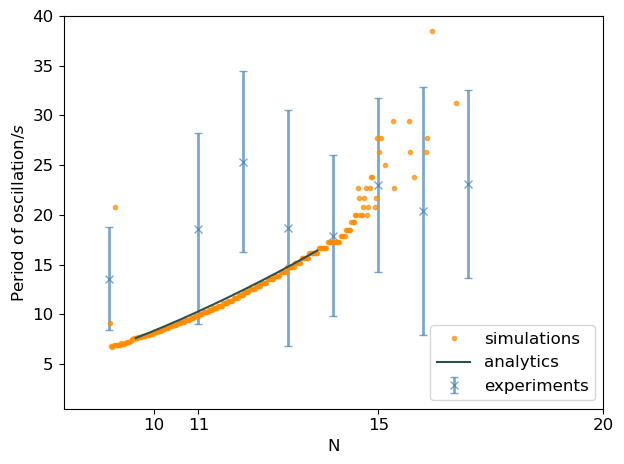

In [48]:
from matplotlib.lines import Line2D

plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', size=12)

plt.axhline(y=0, c='k')


Ns = np.unique(period_exp[:, 0])
data_by_x = [period_exp[period_exp[:, 0] == N, 1] for N in Ns]
m = list(map(np.mean, data_by_x))
s = list(map(np.std, data_by_x))

plt.errorbar(Ns, m, yerr=s, fmt='x', color='steelblue', barsabove=True, capsize=3, alpha=0.7, label=r'experiments', linewidth=2)
plt.plot(ratios*10+1, period_sim, 'darkorange', marker='o', markersize=3, linestyle='none', label=r'simulations', alpha=0.7, markeredgewidth=1)
plt.plot(ratios[period_analytic > 1]*10+1, period_analytic[period_analytic > 1], c='darkslategrey', alpha=1, label=r'analytics')
# plt.plot(period_exp[:, 0], period_exp[:, 1], 'grey', marker='o', markersize=2, linestyle='none', label=r'experiments')
plt.legend(loc='lower right') 


# parts = plt.boxplot(data_by_x, positions=Ns, widths=0.2, showmeans=True, meanprops=dict(marker='x'))
# for median in parts['medians']:
#     median.set_visible(False)


# # Create custom legend
# custom_lines = [
#     Line2D([0], [0], color='grey', lw=4, label=r'Experimental'),
#     Line2D([0], [0], color='steelblue', lw=2, label=r'Analytic'),
#     Line2D([0], [0], color='darkorange', marker='+', markersize=10, linestyle='none', label=r'Simulations')
# ]
# plt.legend(handles=custom_lines, loc='upper right')

plt.xlim([8, 20])
plt.xticks([10, 11, 15, 20])
plt.ylim([0.5, 40])
plt.xlabel('N')
plt.ylabel(r'Period of oscillation/$s$')
plt.tight_layout()
plt.savefig('Figures/re_im_eig.pdf')
plt.show()

In [4]:
N = 15
gamma = 1 
ratios = np.linspace(0.5, 2, N)
c_map = 14.5 
c_traj = c_map*ratios
mu_map = 0.1 
mu_traj = mu_map/ratios**2
epsilon_map = 0.374
epsilon_traj = epsilon_map/ratios**4 

beta = 14.25*gamma
sigma_traj = 0.05/ratios**1.5

n_repeats = 5
init = [0, 0]

stds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    
    dt = max(1/epsilon/5e3, 6.6e-3)
    dt = min(dt, 0.011)
    T = max(1/epsilon*30, 170)
    n_frames = int(T/0.033)
    print(ratios[i]*10+1, dt, T)
    
    params = [epsilon, gamma, mu, c, beta, sigma]
    m = FHN(params, convert_params, m_err = [0.002, 0.04])
    results =  np.array(m.evolve(T, dt, int(n_frames), n_repeats))
    results = results[:, :, -5000:]
    std = np.std(results[:, 0, :], axis=-1)
    stds.append(std) 

np.save('Data/theta_var.npy', np.array(stds)**2)

6.0 0.0066 170
7.071428571428571 0.0066 170
8.142857142857142 0.0066 170
9.214285714285714 0.0066 170
10.285714285714286 0.0066 170
11.357142857142856 0.0066 170
12.428571428571427 0.0066 170
13.5 0.0066 195.83472593582886
14.571428571428573 0.0066 272.1146436311074
15.642857142857142 0.0066 368.7677674270078
16.714285714285715 0.0066 489.1344292819169
17.785714285714285 0.0066 636.8086572523259
18.857142857142854 0.0066 815.6381754928314
19.928571428571427 0.0068648293617075765 1029.7244042561365
21.0 0.008556149732620321 1283.4224598930482


In [5]:
N = 15
gamma = 1 
ratios = np.linspace(0.5, 2, N)
c_map = 0 
c_traj = c_map*ratios
mu_map = 0 
mu_traj = mu_map/ratios**2
epsilon_map = 0.374
epsilon_traj = epsilon_map/ratios**4 

beta = 0 
sigma_traj = 0.05/ratios**1.5

T = 0.033*n_frames
n_frames = 5000
n_repeats = 5
init = [0, 0]

stds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    
    pred = np.sqrt(sigma**2/(2*epsilon))
    params = [epsilon, gamma, mu, c, beta, sigma]
    m = FHN(params, convert_params, m_err = [0.002, 0.04])

    dt = max(1/epsilon/5e3, 6.6e-3)
    dt = min(dt, 0.011)
    T = max(1/epsilon*30, 170)
    n_frames = int(T/0.033)
    print(ratios[i]*10+1, dt, T)
    results =  np.array(m.evolve(T, dt, int(n_frames), n_repeats))
    std = np.std(results[:, 0, -5000:], axis=-1)
    stds.append(std) 

np.save('Data/eq_var.npy', np.array(stds)**2)
        

6.0 0.0066 170
7.071428571428571 0.0066 170
8.142857142857142 0.0066 170
9.214285714285714 0.0066 170
10.285714285714286 0.0066 170
11.357142857142856 0.0066 170
12.428571428571427 0.0066 170
13.5 0.0066 195.83472593582886
14.571428571428573 0.0066 272.1146436311074
15.642857142857142 0.0066 368.7677674270078
16.714285714285715 0.0066 489.1344292819169
17.785714285714285 0.0066 636.8086572523259
18.857142857142854 0.0066 815.6381754928314
19.928571428571427 0.0068648293617075765 1029.7244042561365
21.0 0.008556149732620321 1283.4224598930482


In [6]:
preds = [] 

for (i, (mu, c, epsilon, sigma)) in enumerate(zip(mu_traj, c_traj, epsilon_traj, sigma_traj)):
    preds.append(sigma**2/(2*epsilon))


In [7]:
var = np.load('Data/theta_var.npy')
mean = np.mean(var, axis=-1)
err = np.std(var, axis=-1)

var_eq = np.load('Data/eq_var.npy')
m_eq = np.mean(var_eq, axis=-1)
err_eq = np.std(var_eq, axis=-1)

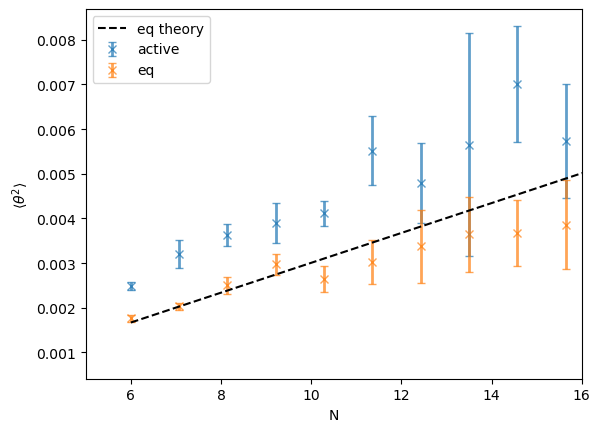

In [10]:
Ls = ratios*10+1
plt.errorbar(Ls, mean, yerr=err, fmt='x', barsabove=True, capsize=3, alpha=0.7, label=r'active', linewidth=2)
plt.errorbar(Ls, m_eq, yerr=err_eq, fmt='x', barsabove=True, capsize=3, alpha=0.7, label=r'eq', linewidth=2)
plt.plot(Ls, preds, 'k--', label=r'eq theory')
plt.legend() 
plt.ylabel(r'$\langle \theta^2 \rangle$')
plt.xlabel(r'N')
plt.xlim([5, 16])
plt.show() 